In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
import json
import torch

sns.set(context="paper", style="whitegrid", font_scale=1.5)
%matplotlib inline

## Setup

In [2]:
exp_name = "200904_mnist"
use_eval_runs = True
exp_type = "mnist"

In [3]:
train_files = f"../results/{exp_name}/*/config.json"
eval_files = f"../results/{exp_name}/*/eval/*/config.json"

In [4]:
if use_eval_runs:
    files = eval_files
else:
    files = train_files

In [5]:
if exp_type == "mnist":
    calibration_data = "rotated_mnist"
    ood_data = "fashion_mnist"
elif exp_type == "cifar10":
    calibration_data = "cifar10c"
    ood_data = "svhn"
else:
    raise ValueError(f"Unknown experiment type {exp_type}")

In [6]:
monolithic_priors = ["gaussian", "laplace", "student-t", "cauchy"]
hierarchical_priors = ["gaussian_gamma", "laplace_gamma", "student-t_gamma", "horseshoe", "mixture"]

In [7]:
def plot_grid(runs, y, yerr=None, ylabel="performance", ylim=None, x="weight_prior"):
    scales = sorted(runs.weight_scale.unique())
    temps = sorted(runs.temperature.unique())
    fig, axes = plt.subplots(len(scales), len(temps), sharex=True, sharey=True, figsize=(10,10))

    for scale, axs in zip(scales, axes):
        for temp, ax in zip(temps, axs):
            df = runs.sort_values([x, "weight_scale"]).query(f"weight_scale == {scale} & temperature == {temp}")
            df.plot(x=x, y=y, yerr=yerr, kind="bar", legend=False, ax=ax)
            ax.set_title(f"scale={scale} and T={temp}")
            ax.set_ylabel(ylabel)
            if ylim is not None:
                ax.set_ylim(ylim)

    fig.tight_layout()
    return fig

## Load results

In [8]:
runs = []
for config_file in glob(files):
    with open(config_file) as infile:
        config = pd.Series(json.load(infile))
    with open(config_file[:-11] + "run.json") as infile:
        result = pd.Series(json.load(infile)["result"], dtype=np.float32)
    run_data = pd.concat([config, result])
    runs.append(run_data)
runs_all = pd.concat(runs, axis=1).T

In [9]:
runs_all["error_mean"] = 1. - runs_all["acc_mean"]

In [10]:
runs_all.head()

,accuracy_eval,batch_size,batchnorm,bias_loc,bias_prior,bias_prior_params,bias_scale,burnin,calibration_eval,config_file,...,auroc,lp_mean,lp_std,lp_stderr,ace,ece,rmsce,simple_logmarglik,simple_marglik,error_mean
0,True,64,True,0,gaussian,{},1,10,False,../results/200904_mnist/21/config.json,...,0.808328,-7.17805,4.44838,0.0444838,NaN,NaN,NaN,NaN,NaN,0.929901
1,True,64,True,0,gaussian,{},1,10,True,../results/200904_mnist/21/config.json,...,NaN,-0.90996,1.88963,0.0109098,0.0207254,0.0787537,0.00668745,NaN,NaN,0.237976
2,True,64,True,0,gaussian,{},1,10,False,../results/200904_mnist/21/config.json,...,NaN,-0.0757862,0.3253,0.00325299,NaN,NaN,NaN,-1.40421e+06,0,0.027534
3,True,64,True,0,gaussian,{},1,10,False,../results/200904_mnist/84/config.json,...,0.727091,-2.44494,0.393098,0.00393098,NaN,NaN,NaN,NaN,NaN,0.917955
4,True,64,True,0,gaussian,{},1,10,False,../results/200904_mnist/84/config.json,...,NaN,-1.5064,0.421688,0.00421688,NaN,NaN,NaN,-8.30361e+08,0,0.640009


## Evaluate predictive performance

In [11]:
if use_eval_runs:
    runs_selected = runs_all.query("eval_data != eval_data")  # basically checks for None
else:
    runs_selected = runs_all

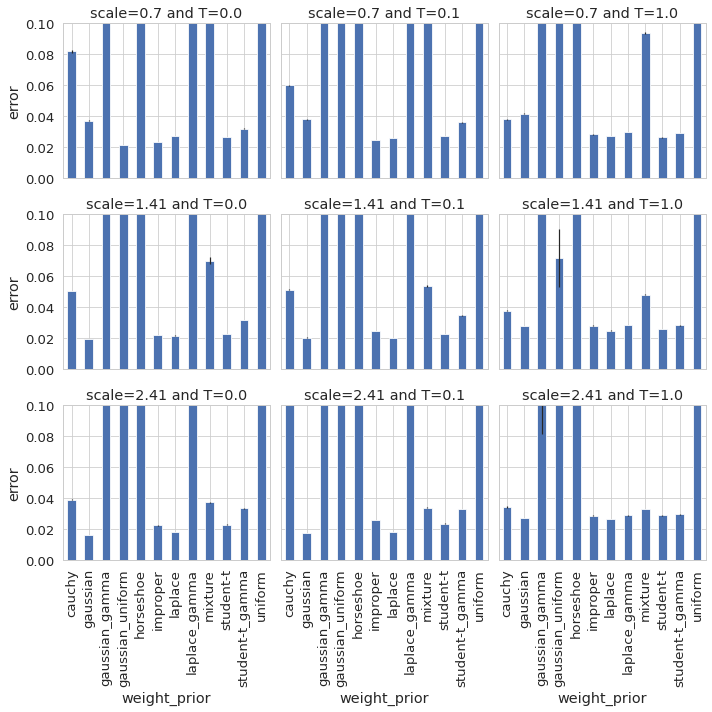

In [12]:
fig = plot_grid(runs_selected, y="error_mean", yerr="acc_stderr", ylabel="error", ylim=(0, 0.1))

In [13]:
fig.savefig(f"../figures/{exp_name}_acc.pdf")

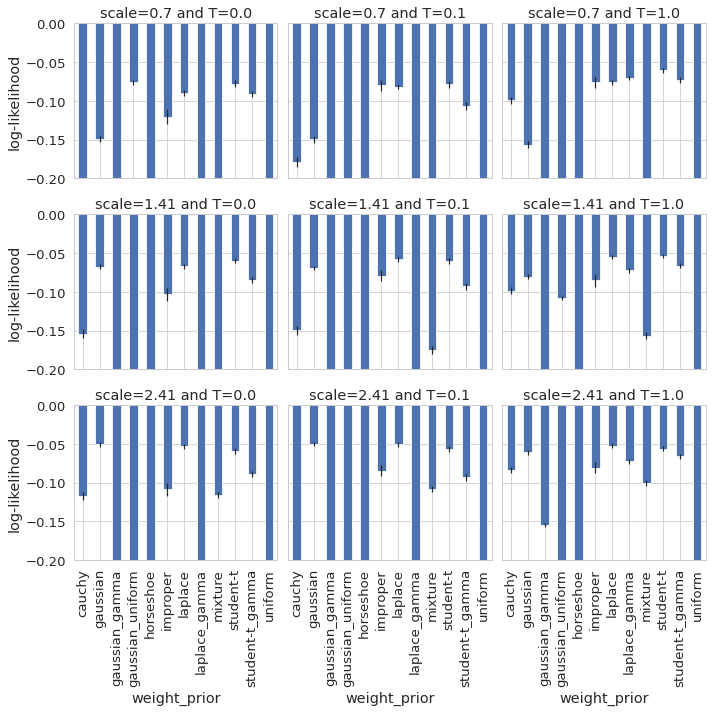

In [14]:
fig = plot_grid(runs_selected, y="lp_mean", yerr="lp_stderr", ylabel="log-likelihood", ylim=(-0.2, 0))

In [15]:
fig.savefig(f"../figures/{exp_name}_ll.pdf")

In [16]:
runs_subselected = runs_selected.query(f"weight_prior in {monolithic_priors}")

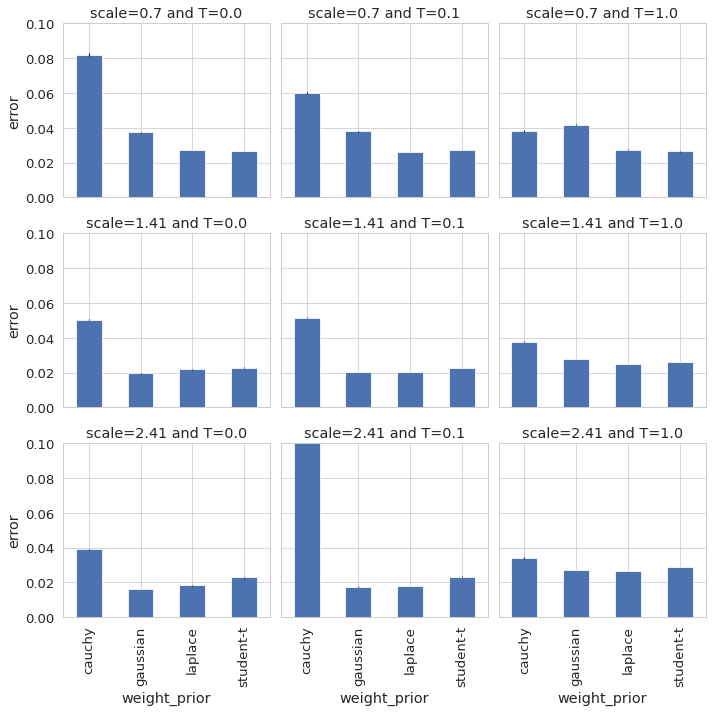

In [17]:
fig = plot_grid(runs_subselected, y="error_mean", yerr="acc_stderr", ylabel="error", ylim=(0, 0.1))

In [18]:
fig.savefig(f"../figures/{exp_name}_acc_monolithic.pdf")

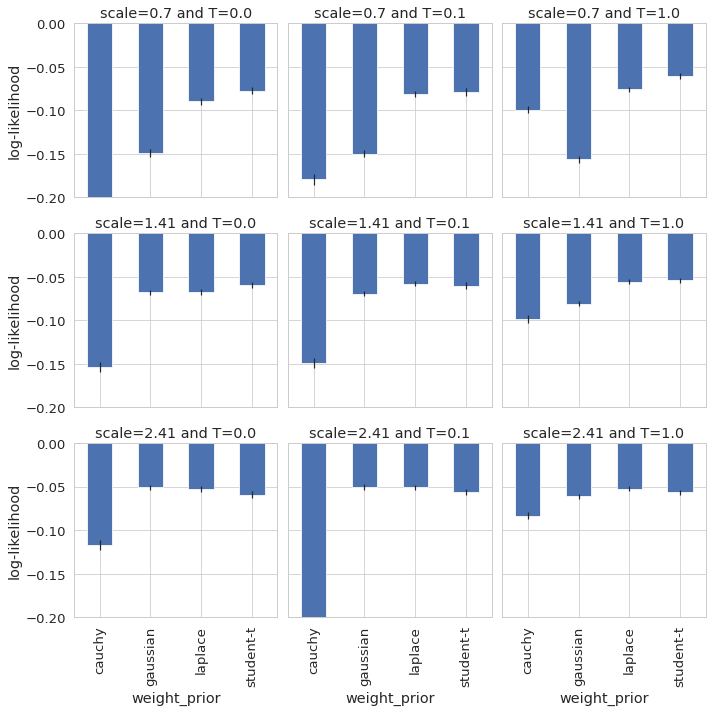

In [19]:
fig = plot_grid(runs_subselected, y="lp_mean", yerr="lp_stderr", ylabel="log-likelihood", ylim=(-0.2, 0))

In [20]:
fig.savefig(f"../figures/{exp_name}_ll_monolithic.pdf")

In [21]:
runs_subselected = runs_selected.query(f"weight_prior in {hierarchical_priors}")

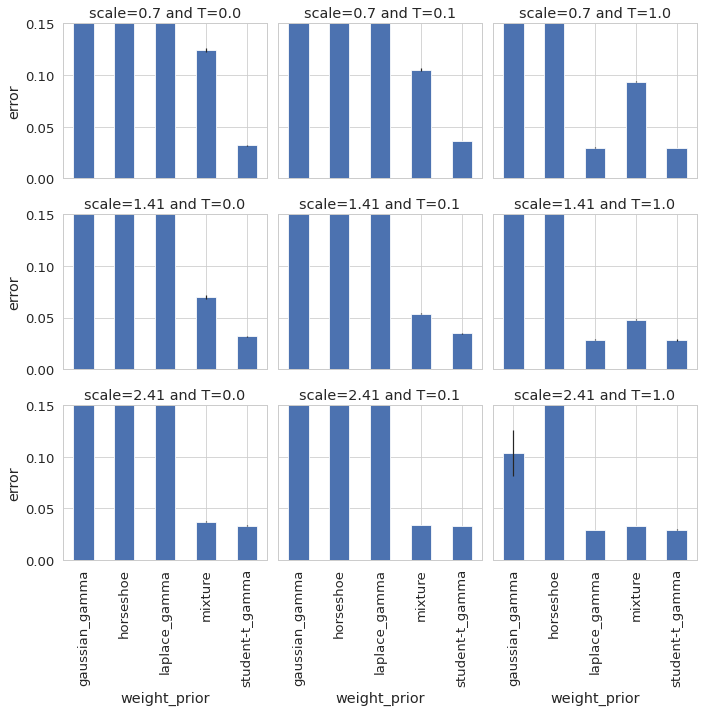

In [22]:
fig = plot_grid(runs_subselected, y="error_mean", yerr="acc_stderr", ylabel="error", ylim=(0, 0.15))

In [23]:
fig.savefig(f"../figures/{exp_name}_acc_hierarchical.pdf")

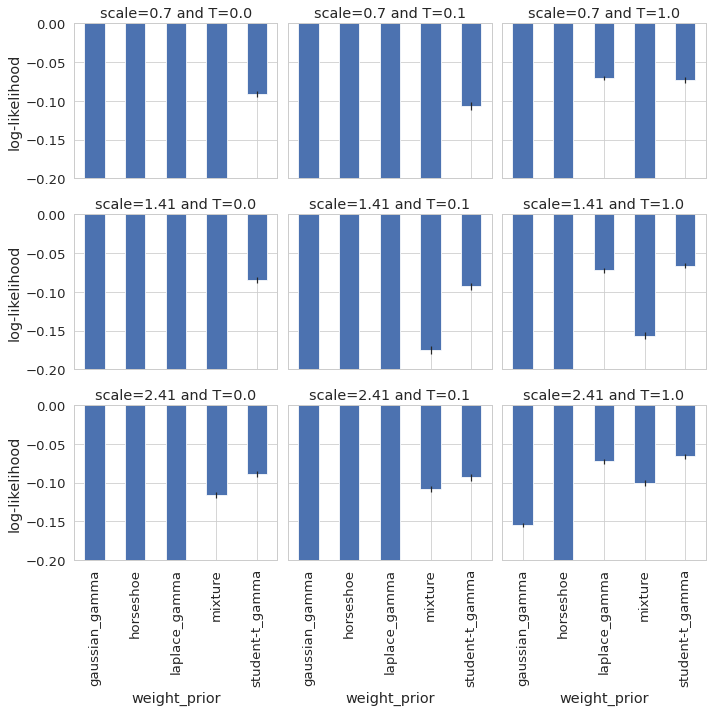

In [24]:
fig = plot_grid(runs_subselected, y="lp_mean", yerr="lp_stderr", ylabel="log-likelihood", ylim=(-0.2, 0))

In [25]:
fig.savefig(f"../figures/{exp_name}_ll_hierarchical.pdf")

Try to run that for longer

## Evaluate mixture models

In [26]:
components = ["gaussian", "laplace", "student-t", "cauchy"]

df_mixture = pd.DataFrame(columns=["weight_scale", "temperature", "layer", "component", "weight", "log_weight"])

for config_file in glob(train_files):
    with open(config_file) as infile:
        config = pd.Series(json.load(infile))
    if config["weight_prior"] == "mixture" and config["weight_prior_params"]=={}:
        samples = torch.load(os.path.join(os.path.dirname(config_file),"samples.pt"))
        mixture_weights = {k[:5]:torch.nn.functional.softmax(v[-1], dim=0).detach().numpy()
                   for k, v in samples.items() if "mixture_weights" in k}
        scale = config['weight_scale']
        temp = config['temperature']
        for layer, weights in mixture_weights.items():
            for comp, weight in zip(components, weights):
                df_mixture.loc[len(df_mixture)] = [scale, temp, layer, comp, weight, np.log(weight)]

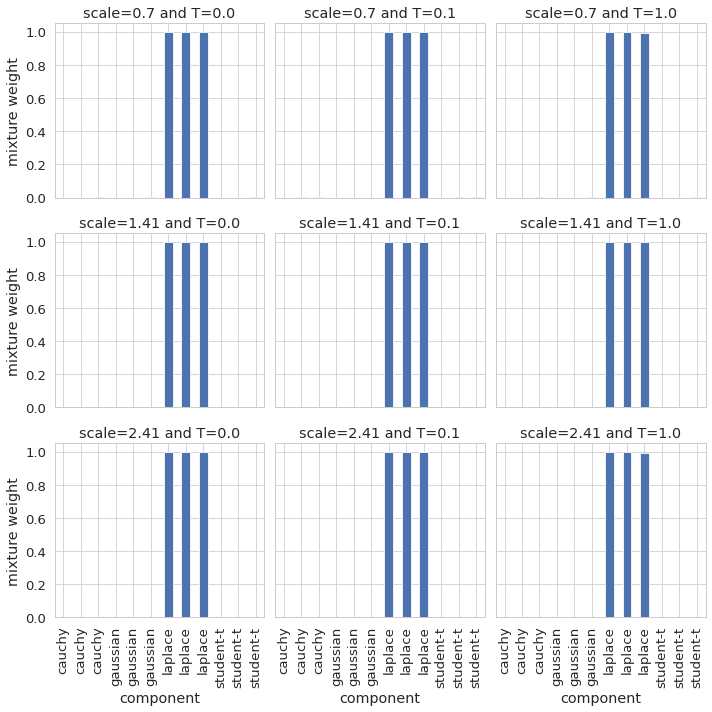

In [27]:
fig = plot_grid(df_mixture, y="weight", ylabel="mixture weight", x="component")

In [28]:
fig.savefig(f"../figures/{exp_name}_mixture_weights.pdf")

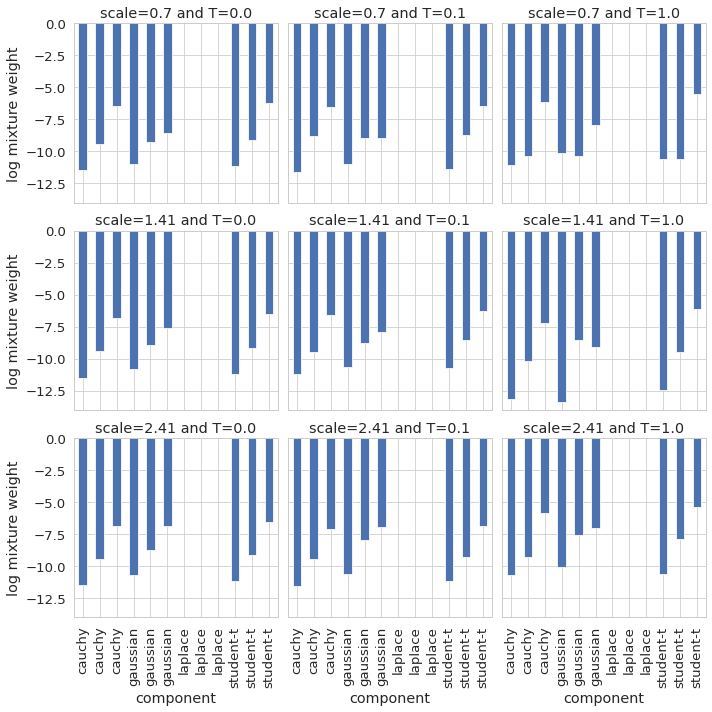

In [29]:
fig = plot_grid(df_mixture, y="log_weight", ylabel="log mixture weight", x="component")

In [30]:
fig.savefig(f"../figures/{exp_name}_mixture_logweights.pdf")

## Evaluate marginal likelihood

In [31]:
runs_selected = runs_selected[runs_selected.weight_prior.apply(lambda val: val not in ["improper", "uniform", "mixture"])]

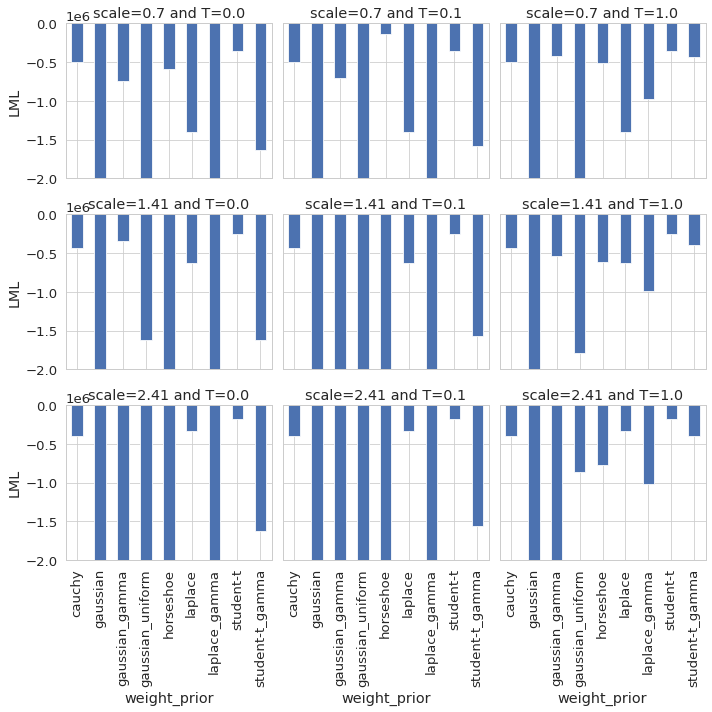

In [32]:
fig = plot_grid(runs_selected, y="simple_logmarglik", ylabel="LML", ylim=(-2e6, 0.))

In [33]:
fig.savefig(f"../figures/{exp_name}_logmargliks.pdf")

In [34]:
runs_subselected = runs_selected.query(f"weight_prior in {monolithic_priors}")

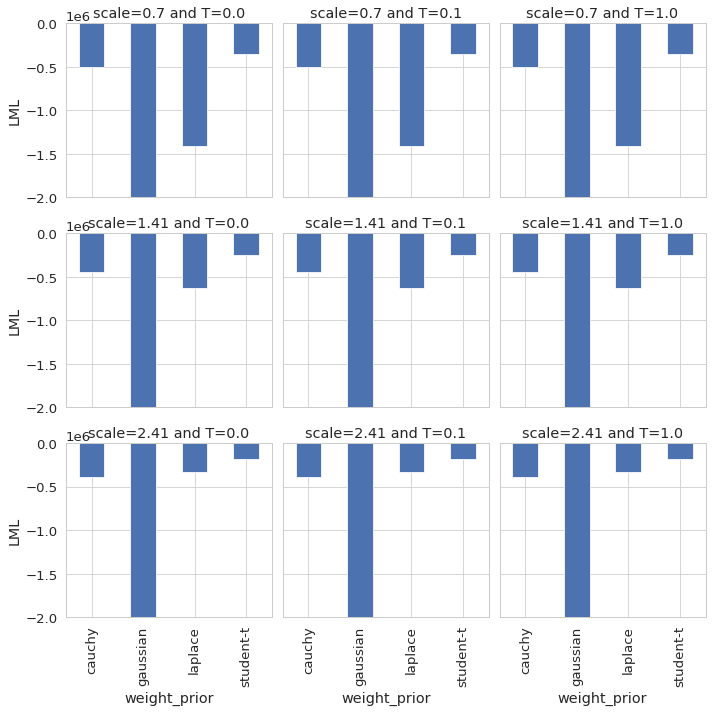

In [35]:
fig = plot_grid(runs_subselected, y="simple_logmarglik", ylabel="LML", ylim=(-2e6, 0.))

In [36]:
fig.savefig(f"../figures/{exp_name}_logmargliks_monolithic.pdf")

In [37]:
margliks = runs_selected["simple_logmarglik"].values.astype(float)
lls = runs_selected["lp_mean"].values.astype(float)
accs = runs_selected["acc_mean"].values.astype(float)

In [38]:
print("Correlation between log marginal likelihoods and test log likelihoods:")
print("Pearson's r = {0:.3f} with p-value = {1:.2e}".format(*stats.pearsonr(margliks, lls)))
print("Spearman's rho = {0:.3f} with p-value = {1:.2e}".format(*stats.spearmanr(margliks, lls)))
print("Kendall's tau = {0:.3f} with p-value = {1:.2e}".format(*stats.kendalltau(margliks, lls)))

print("Correlation between log marginal likelihoods and test errors:")
print("Pearson's r = {0:.3f} with p-value = {1:.2e}".format(*stats.pearsonr(margliks, accs)))
print("Spearman's rho = {0:.3f} with p-value = {1:.2e}".format(*stats.spearmanr(margliks, accs)))
print("Kendall's tau = {0:.3f} with p-value = {1:.2e}".format(*stats.kendalltau(margliks, accs)))

Correlation between log marginal likelihoods and test log likelihoods:
Pearson's r = 0.377 with p-value = 5.24e-04
Spearman's rho = 0.470 with p-value = 9.59e-06
Kendall's tau = 0.360 with p-value = 2.17e-06
Correlation between log marginal likelihoods and test errors:
Pearson's r = 0.377 with p-value = 5.30e-04
Spearman's rho = 0.408 with p-value = 1.59e-04
Kendall's tau = 0.310 with p-value = 4.96e-05


In [39]:
priors = runs_selected.weight_prior.unique()
for prior in priors:
    print(f"Testing {prior} prior")

    runs_subselected = runs_selected.query(f"weight_prior == '{prior}'")
    margliks = runs_subselected["simple_logmarglik"].values.astype(float)
    lls = runs_subselected["lp_mean"].values.astype(float)
    accs = runs_subselected["acc_mean"].values.astype(float)

    print("Correlation between log marginal likelihoods and test log likelihoods:")
    print("Pearson's r = {0:.3f} with p-value = {1:.2e}".format(*stats.pearsonr(margliks, lls)))
    print("Spearman's rho = {0:.3f} with p-value = {1:.2e}".format(*stats.spearmanr(margliks, lls)))
    print("Kendall's tau = {0:.3f} with p-value = {1:.2e}".format(*stats.kendalltau(margliks, lls)))

    print("Correlation between log marginal likelihoods and test errors:")
    print("Pearson's r = {0:.3f} with p-value = {1:.2e}".format(*stats.pearsonr(margliks, accs)))
    print("Spearman's rho = {0:.3f} with p-value = {1:.2e}".format(*stats.spearmanr(margliks, accs)))
    print("Kendall's tau = {0:.3f} with p-value = {1:.2e}".format(*stats.kendalltau(margliks, accs)))
    print("")

Testing laplace prior
Correlation between log marginal likelihoods and test log likelihoods:
Pearson's r = 0.947 with p-value = 1.10e-04
Spearman's rho = 0.949 with p-value = 9.58e-05
Kendall's tau = 0.866 with p-value = 2.70e-03
Correlation between log marginal likelihoods and test errors:
Pearson's r = 0.712 with p-value = 3.13e-02
Spearman's rho = 0.685 with p-value = 4.17e-02
Kendall's tau = 0.609 with p-value = 3.48e-02

Testing laplace_gamma prior
Correlation between log marginal likelihoods and test log likelihoods:
Pearson's r = 0.986 with p-value = 1.05e-06
Spearman's rho = 0.933 with p-value = 2.36e-04
Kendall's tau = 0.833 with p-value = 8.54e-04
Correlation between log marginal likelihoods and test errors:
Pearson's r = 0.983 with p-value = 1.96e-06
Spearman's rho = 0.900 with p-value = 9.43e-04
Kendall's tau = 0.778 with p-value = 2.43e-03

Testing gaussian_uniform prior
Correlation between log marginal likelihoods and test log likelihoods:
Pearson's r = 0.363 with p-value

## Evaluate calibration

In [40]:
assert use_eval_runs, "The calibration and OOD can only be assessed on eval data"

In [41]:
runs_selected = runs_all.query(f"'{calibration_data}' in eval_data")

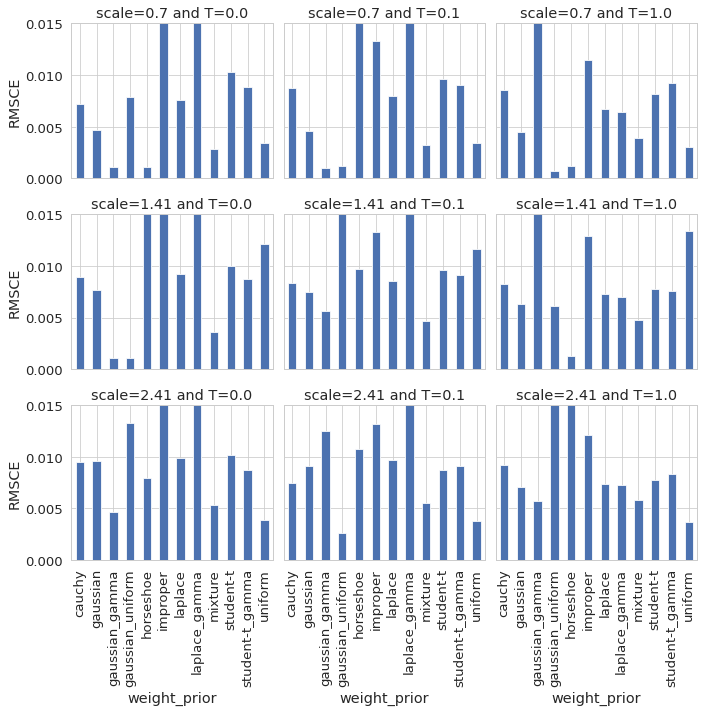

In [42]:
fig = plot_grid(runs_selected, y="rmsce", ylabel="RMSCE", ylim=(0, 0.015))

In [43]:
fig.savefig(f"../figures/{exp_name}_rmsce.pdf")

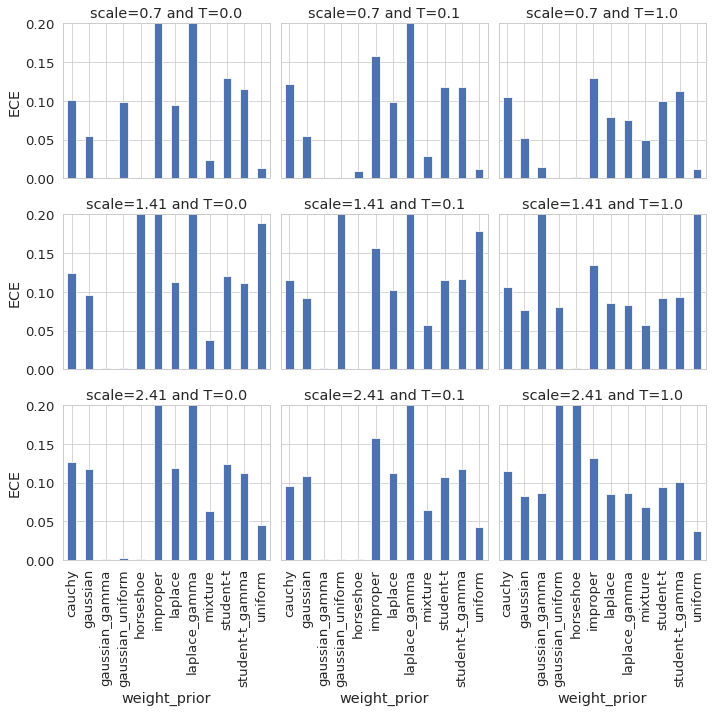

In [44]:
fig = plot_grid(runs_selected, y="ece", ylabel="ECE", ylim=(0, 0.2))

In [45]:
fig.savefig(f"../figures/{exp_name}_ece.pdf")

In [46]:
runs_subselected = runs_selected.query(f"weight_prior in {monolithic_priors}")

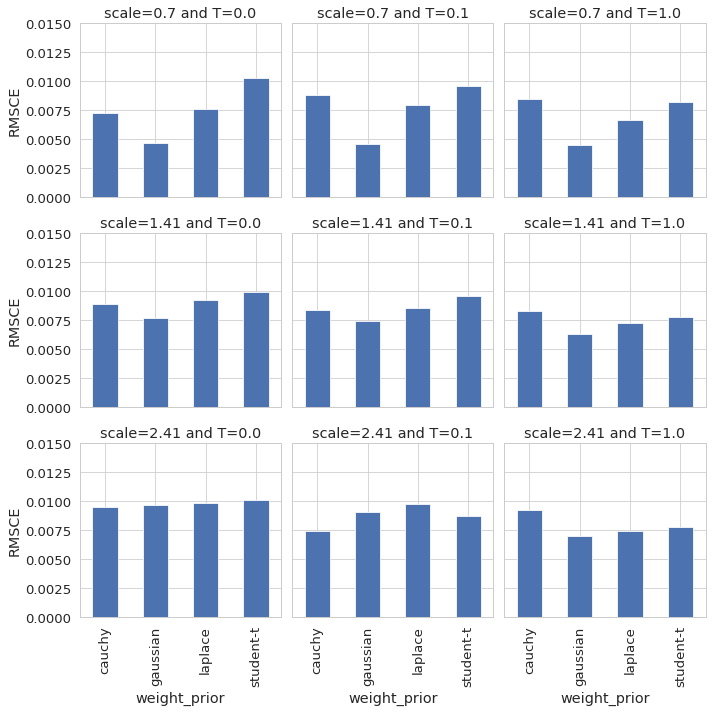

In [47]:
fig = plot_grid(runs_subselected, y="rmsce", ylabel="RMSCE", ylim=(0, 0.015))

In [48]:
fig.savefig(f"../figures/{exp_name}_rmsce_monolithic.pdf")

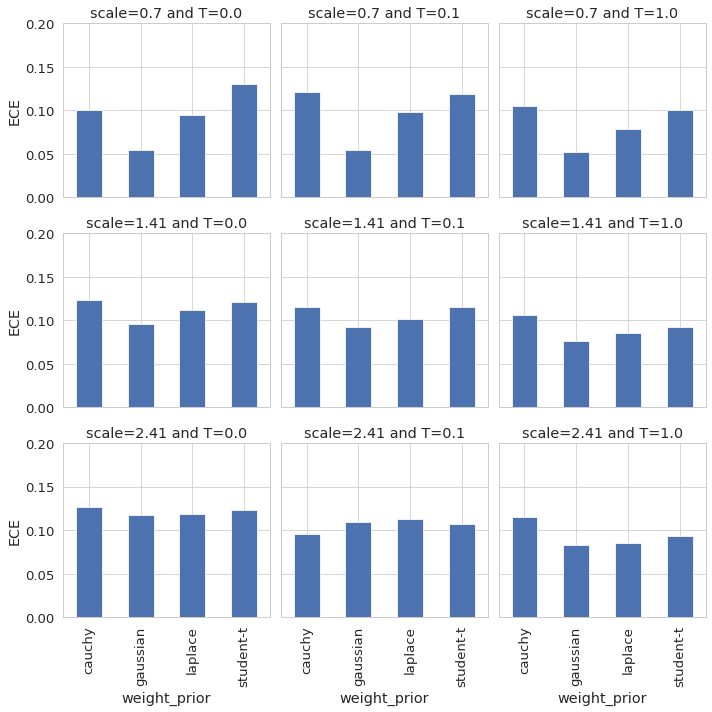

In [49]:
fig = plot_grid(runs_subselected, y="ece", ylabel="ECE", ylim=(0, 0.2))

In [50]:
fig.savefig(f"../figures/{exp_name}_ece_monolithic.pdf")

## Evaluate OOD detection

In [51]:
runs_selected = runs_all.query(f"'{ood_data}' in eval_data")

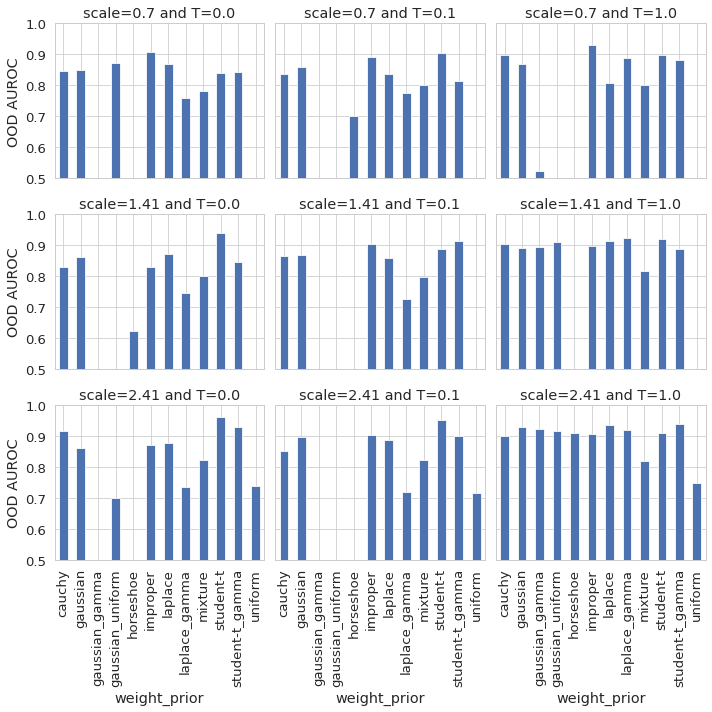

In [52]:
fig = plot_grid(runs_selected, y="auroc", ylabel="OOD AUROC", ylim=(0.5, 1.))

In [53]:
fig.savefig(f"../figures/{exp_name}_ood.pdf")

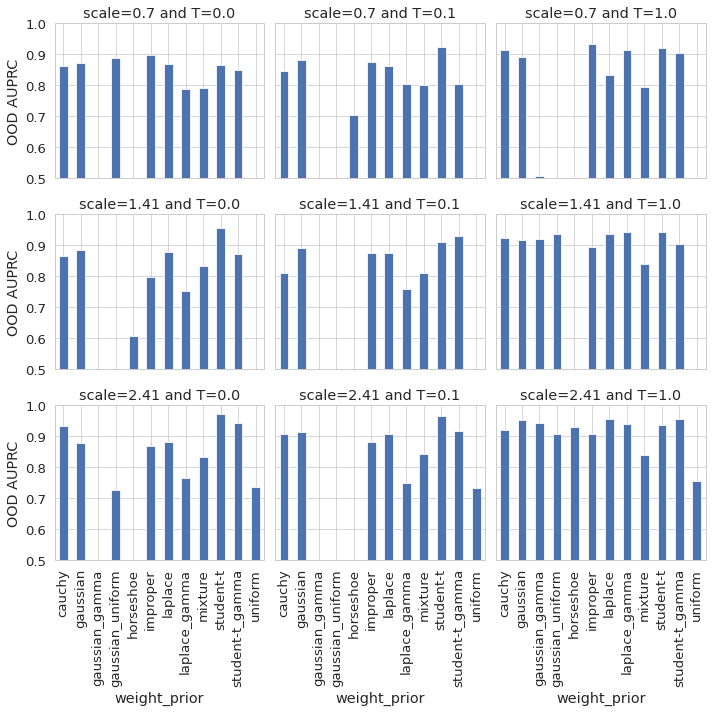

In [54]:
fig = plot_grid(runs_selected, y="auprc", ylabel="OOD AUPRC", ylim=(0.5, 1.))

In [55]:
fig.savefig(f"../figures/{exp_name}_ood.pdf")

In [56]:
runs_subselected = runs_selected.query(f"weight_prior in {monolithic_priors}")

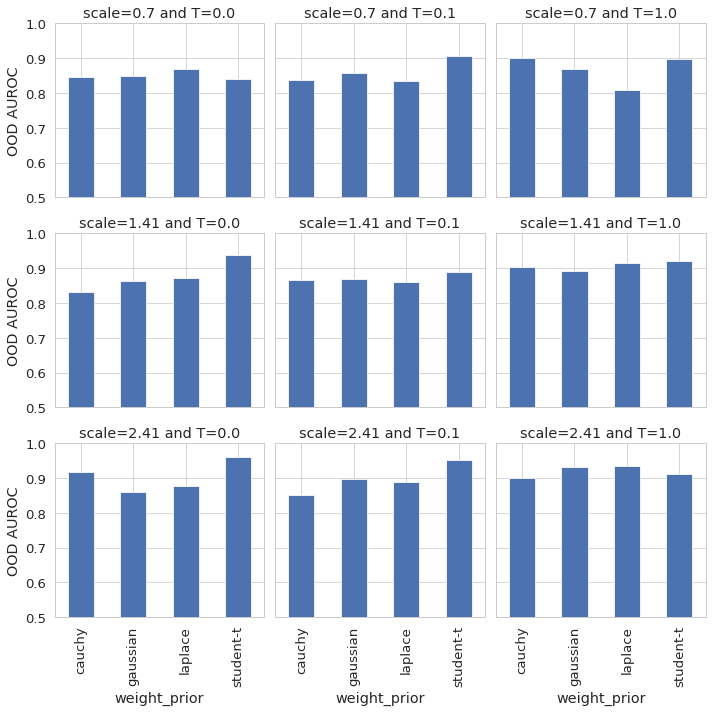

In [57]:
fig = plot_grid(runs_subselected, y="auroc", ylabel="OOD AUROC", ylim=(0.5, 1.))

In [58]:
fig.savefig(f"../figures/{exp_name}_ood_monolithic.pdf")

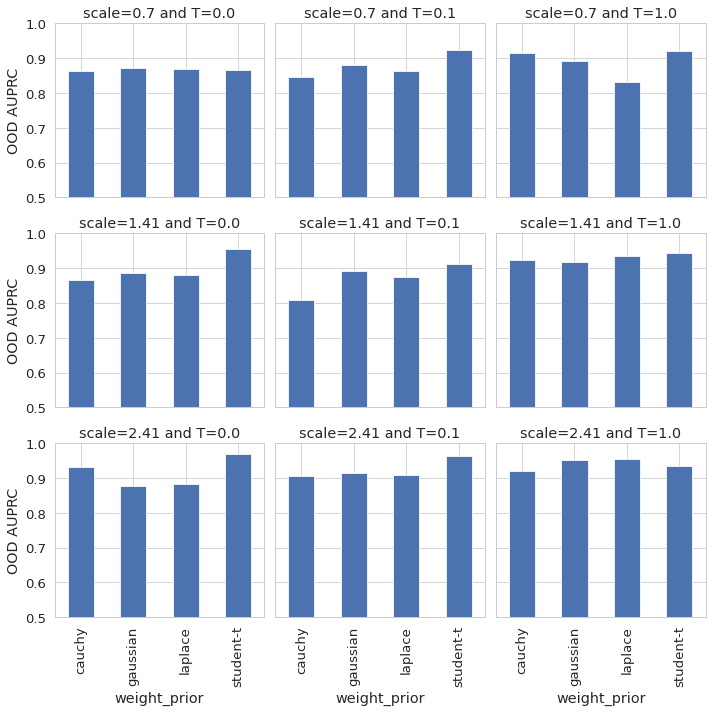

In [59]:
fig = plot_grid(runs_subselected, y="auprc", ylabel="OOD AUPRC", ylim=(0.5, 1.))

In [60]:
fig.savefig(f"../figures/{exp_name}_ood_monolithic.pdf")

## Evaluate empirical distribution of weights

In [61]:
# Adapted from https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python

import scipy.stats as st
import warnings
import tqdm

# Create models from data
def best_fit_distribution(data, bins=200):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [st.cauchy,st.gennorm,st.laplace,
                     st.loglaplace,st.norm,st.t,st.uniform]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf
    
    sses = {}

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:
        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                sses[distribution.name] = sse

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            f"Failed to fit {distribution}"

    return (best_distribution.name, best_params, sses)

In [62]:
final_weights = None
for config_file in glob(train_files):
    with open(config_file) as infile:
        config = pd.Series(json.load(infile))
    if config["weight_prior"] == "improper":
        samples = torch.load(os.path.join(os.path.dirname(config_file),"samples.pt"))
        final_weights_sample = {param : val[-1] for param, val in samples.items() if "weight_prior" in param}
        if final_weights is None:
            final_weights = final_weights_sample
        else:
            final_weights = {param: torch.cat((final_weights[param], val)) for param, val in final_weights_sample.items()}
final_weights = {param: val.detach().numpy().flatten() for param, val in final_weights.items()}

net.0.weight_prior.p gennorm (0.5198410874527308, -0.0009128944958438985, 0.06826813891545402)
net.2.weight_prior.p gennorm (0.7780420282941223, -0.008158074404282355, 0.26497922839776245)
net.4.weight_prior.p loglaplace (150.09653934469964, -77.44190789076387, 77.4407312829934)


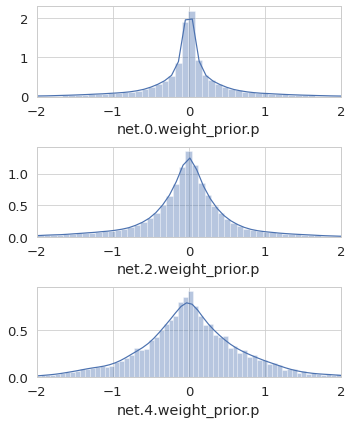

In [63]:
layer_fits = {}
fig, axs = plt.subplots(nrows=len(final_weights), figsize=(5, 2*len(final_weights)))
for (param, weights), ax in zip(final_weights.items(), axs):
    sns.distplot(weights, ax=ax, bins=100)
    ax.set_xlabel(param)
    ax.set_xlim((-2, 2))
    best_fit_name, best_fit_params, sses = best_fit_distribution(weights, 200)
    print(param, best_fit_name, best_fit_params)
    layer_fits[param] = {k: v for i, (k, v) in enumerate(sorted(sses.items(), key=lambda item: item[1])) if i<5}
fig.tight_layout()

In [64]:
fig.savefig(f"../figures/{exp_name}_empirical_weightdist.pdf")

In [65]:
for param, fits in layer_fits.items():
    print(f"Best fit for {param} weigths: ",", ".join([f"{dist} ({err:.2f})" for dist, err in fits.items()]))

Best fit for net.0.weight_prior.p weigths:  gennorm (0.23), cauchy (1.34), t (1.87), loglaplace (3.75), laplace (3.75)
Best fit for net.2.weight_prior.p weigths:  gennorm (0.05), cauchy (0.11), loglaplace (0.25), laplace (0.26), t (0.27)
Best fit for net.4.weight_prior.p weigths:  loglaplace (0.15), laplace (0.15), gennorm (0.16), t (0.43), cauchy (0.46)


In [66]:
for param, weight in final_weights.items():
    print(f"Normality tests for {param}:")
    print(f"Mean = {weight.mean():.2f}, std = {weight.flatten().std():.2f}")
    print("D'Angostino: statistic = {0:.2f}, p-value = {1:.2e}".format(*stats.normaltest(weight)))
    print("Shapiro: statistic = {0:.2f}, p-value = {1:.2e}".format(*stats.shapiro(np.random.choice(weight, size=5000, replace=False))))

Normality tests for net.0.weight_prior.p:
Mean = -0.01, std = 0.56
D'Angostino: statistic = 71336.21, p-value = 0.00e+00
Shapiro: statistic = 0.89, p-value = 0.00e+00
Normality tests for net.2.weight_prior.p:
Mean = -0.04, std = 0.62
D'Angostino: statistic = 9247.20, p-value = 0.00e+00
Shapiro: statistic = 0.93, p-value = 1.63e-43
Normality tests for net.4.weight_prior.p:
Mean = 0.01, std = 0.70
D'Angostino: statistic = 204.43, p-value = 4.06e-45
Shapiro: statistic = 0.99, p-value = 1.31e-20
